In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
# general
import os
import numpy as np
from tqdm import tqdm
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
import arviz
from getdist import plots, MCSamples
# numpyro
import numpyro
import numpyro.distributions as npyro_dist
from numpyro.infer import MCMC, NUTS
# # NF
import torch
import pyro
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Probability distribution

In [3]:
def gauss(x, m, s):
    return np.exp(-0.5*((x-m)/s)**2)/np.sqrt(2*np.pi*s**2)

def gauss_mixture(x, means, stds, ratios=None):
    if ratios is None:
        ratios = np.ones(len(means))/len(means)
    return np.sum([ratios[i]/sum(ratios)*gauss(x, means[i], stds[i]) for i in range(len(means))], axis=0)

def gauss_generator(rng, m, s, size):
    return m + s*rng.normal(size=size)

def gauss_mixture_generator(rng, means, stds, size, ratios=None):
    if ratios is None:
        ratios = [1/len(means) for _ in range(len(means))]
    # normalize ratios
    ratios = np.array(ratios)/sum(ratios)

    # determine the number of samples for each component
    unit = rng.uniform(0, 1, size=size)
    sizes= []
    for i in range(len(means)):
        sel = (np.sum(ratios[:i]) < unit) & (unit < np.sum(ratios[:i+1]))
        sizes.append(np.sum(sel))
    assert np.sum(sizes) == size, 'Sizes do not match {}!={}'.format(size, np.sum(sizes))

    samples = []
    for i in range(len(means)):
        samples.append(gauss_generator(rng, means[i], stds[i], sizes[i]))
    samples = np.concatenate(samples)

    return samples

In [4]:
x = np.linspace(-3, 3, 500)
# means = [-1, 1, 2]
# stds = [0.5, 0.3, 0.2]
# ratios = [0.5, 0.15, 0.3]
# means = [-2]
# stds = [0.5]
# ratios = [0.5]
means = [-1, -1, -1]
stds = [0.5, 0.7, 0.15]
ratios = [0.5, 0.5, 0.5]
rng = np.random.default_rng(0)

y = gauss_mixture(x, means, stds, ratios)
s = gauss_mixture_generator(rng, means, stds, 10000, ratios)

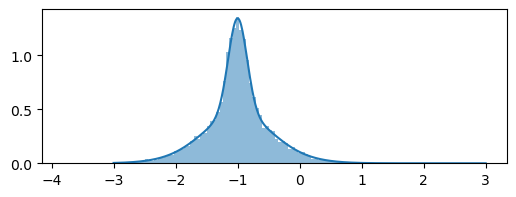

In [54]:
plt.figure(figsize=(6, 2))
plt.plot(x, y, color='C0')
plt.hist(s, bins=100, density=True, alpha=0.5, color='C0')
plt.show()

In [59]:
w = 1.5
stds_w = [std/w for std in stds]

y_w = gauss_mixture(x, means, stds_w, ratios)
s_w = gauss_mixture_generator(rng, means, stds_w, 10000, ratios)

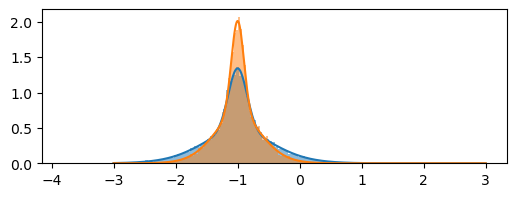

In [60]:
plt.figure(figsize=(6, 2))
plt.plot(x, y, color='C0')
plt.hist(s, bins=100, density=True, alpha=0.5, color='C0')
plt.plot(x, y_w, color='C1')
plt.hist(s_w, bins=100, density=True, alpha=0.5, color='C1')
plt.show()

## Generate sample for training

In [110]:
y_samples = rng.uniform(-1.0, 1.0, 20000)
x_samples = []
for _ in y_samples:
    y_nlin = np.sin(_*np.pi*4)
    means_now = [m+y_nlin for m in means]
    # means_now = [m+2 for m in means]
    x_samples.append(gauss_mixture_generator(rng, means_now, stds, 1, ratios)[0])
x_samples = np.array(x_samples)

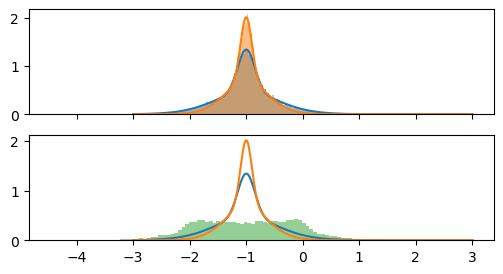

In [111]:
fig, axes = plt.subplots(2,1,figsize=(6, 3), sharex=True)
ax = axes[0]
ax.plot(x, y, color='C0')
ax.hist(s, bins=100, density=True, alpha=0.5, color='C0')
ax.plot(x, y_w, color='C1')
ax.hist(s_w, bins=100, density=True, alpha=0.5, color='C1')
ax = axes[1]
ax.plot(x, y, color='C0')
ax.plot(x, y_w, color='C1')
ax.hist(x_samples, bins=100, density=True, alpha=0.5, color='C2')
plt.show()

In [112]:
samples = np.transpose([x_samples, y_samples])

In [113]:
x_samples.shape, y_samples.shape, samples.shape

((20000,), (20000,), (20000, 2))

## Traning MAF

In [128]:
import flax.linen as nn
import optax
from sklearn import datasets, preprocessing
from tqdm import tqdm

import sys
sys.path.append("../")

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

In [129]:
n_dim = 1
n_context = 1

# flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[32]*10, n_transforms=8, activation="tanh", use_random_permutations=False)
# flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[256]*4, n_transforms=4, activation="tanh", use_random_permutations=False)
flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128]*2, n_transforms=12, activation="gelu", use_random_permutations=False)

# Initialize model
key = jax.random.PRNGKey(42)
x_test = jax.random.uniform(key=key, shape=(64, n_dim))
context = jax.random.uniform(key=key, shape=(64, n_context))
params = flow_model.init(key, x_test, context)

In [130]:
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

@jax.jit
def loss_fn(params, x, context):
    loss = -jnp.mean(flow_model.apply(params, x, context))
    return loss

@jax.jit
def update(params, opt_state, batch):
    x, context = batch
    grads = jax.grad(loss_fn)(params, x, context)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [131]:
%%time
batch_size = 32
# n_steps = 1_000
n_steps = 1_000
loss_history = []

key = jax.random.PRNGKey(0)
for step in tqdm(range(n_steps)):
    # Generate random batch
    key, subkey = jax.random.split(key) # Split key
    indices = jax.random.choice(subkey, samples.shape[0], shape=(batch_size,), replace=False)
    data_batch = np.atleast_2d(samples[indices])
    x_batch = data_batch[:,:n_dim]
    y_batch = data_batch[:,n_dim:]

    # Update
    batch = (x_batch, y_batch)
    params, opt_state = update(params, opt_state, batch)

    # Save loss
    loss_history.append(loss_fn(params, x_batch, y_batch))

100%|██████████| 1000/1000 [00:37<00:00, 26.48it/s]

CPU times: user 35 s, sys: 6.14 s, total: 41.1 s
Wall time: 37.8 s


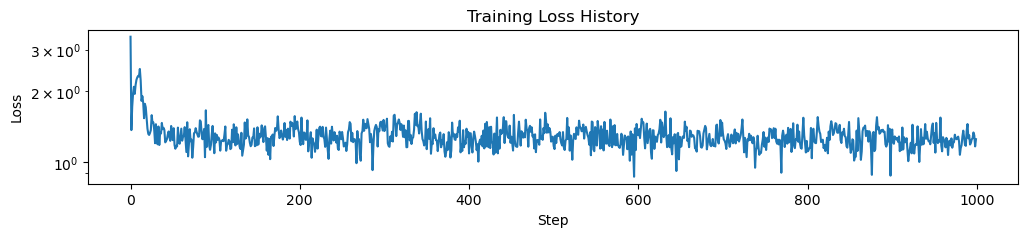

In [132]:
# Plot loss
plt.figure(figsize=(12, 2))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

In [133]:
def sample_from_flow(y, w=1.0, n_samples=10_000, key=jax.random.PRNGKey(42)):
    """Helper function to sample from the flow model.
    """
    if isinstance(y, (int, float)):
        y = jnp.array([y])
    if len(y.shape) == 1:
        y = jnp.ones((n_samples, n_context))*y[None, :]
    assert y.shape == (n_samples, n_context), f"Context shape should be (n_samples, n_context), got {y.shape}"

    def sample_fn(flow_model):
        out = flow_model.sample(num_samples=n_samples, rng=key,
                        context=y, beta=w)
        return out

    out = nn.apply(sample_fn, flow_model)(params)
    out = jnp.array(out)
    return out

In [134]:
y_input = 0.0
x_samples_flow = sample_from_flow(y_input, n_samples=10_000)[:,0]

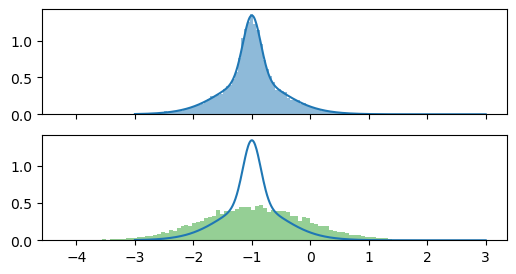

In [135]:
fig, axes = plt.subplots(2,1,figsize=(6, 3), sharex=True)
ax = axes[0]
ax.plot(x, y, color='C0')
ax.hist(s, bins=100, density=True, alpha=0.5, color='C0')
# ax.plot(x, y_w, color='C1')
# ax.hist(s_w, bins=100, density=True, alpha=0.5, color='C1')
ax = axes[1]
ax.plot(x, y, color='C0')
plt.hist(x_samples_flow, bins=100, density=True, alpha=0.5, color='C2')
plt.show()

In [136]:
y_input = 0.0
x_samples_flow_w = sample_from_flow(y_input, w=w, n_samples=10_000)[:,0]

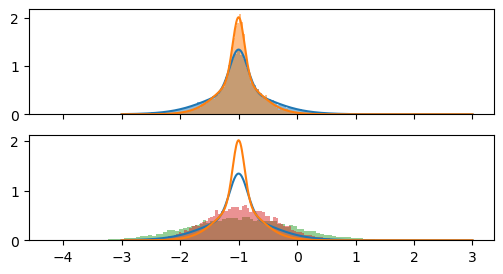

In [137]:
fig, axes = plt.subplots(2,1,figsize=(6, 3), sharex=True)
ax = axes[0]
ax.plot(x, y, color='C0')
ax.hist(s, bins=100, density=True, alpha=0.5, color='C0')
ax.plot(x, y_w, color='C1')
ax.hist(s_w, bins=100, density=True, alpha=0.5, color='C1')
ax = axes[1]
ax.plot(x, y, color='C0')
ax.plot(x, y_w, color='C1')
plt.hist(x_samples_flow, bins=100, density=True, alpha=0.5, color='C2')
plt.hist(x_samples_flow_w, bins=100, density=True, alpha=0.5, color='C3')
plt.show()